# Synthia RAND Experiments
This notebook is meant as an illustration how to reproduce those tables and figures from our paper that are based on the Synthia dataset.  
It also contains useful scripts to download and extract the used datasets and load our pretrained models and experimental configurations.  
To run the notebook for yourself, please follow the [installation instructions from the readme](https://github.com/ethz-asl/modular_semantic_segmentation/blob/publish/README.md).


### *Optional Config and Installation*

Simply jump over the steps you already did set up.

**1. Configuration**

In [ ]:
import xview
from os import path

# PLEASE EDIT THE FOLLOWING PATHS FOR YOUR LOCAL SETTINGS

# path where the image data will be/is stored
DATA_BASEPATH = '/tmp/test'

# path where experiment configs will be stored
EXPERIMENT_STORAGE_FOLDER = '/tmp/exp'

# only change in case you want to use tensorboard for model training, otherwise not relevant
EXP_OUT = '/tmp'

print('writing settings to %s' % path.join(path.dirname(xview.__file__), 'settings.py'))
with open(path.join(path.dirname(xview.__file__), 'settings.py'), 'w') as settings_file:
    settings_file.write("DATA_BASEPATH = '%s'\n" % DATA_BASEPATH)
    settings_file.write("EXPERIMENT_STORAGE_FOLDER = '%s'\n" % EXPERIMENT_STORAGE_FOLDER)
    settings_file.write("EXP_OUT = '%s'\n" % EXP_OUT)

**2. Downloading SYNTHIA data**  
By downloading the SYNTHIA data you accept their [terms of use](http://synthia-dataset.com/terms-of-use/). The data is licensed under [ Creative Commons Attribution-NonCommercial-ShareAlike 3.0](http://creativecommons.org/licenses/by-nc-sa/3.0/legalcode).

In [ ]:
#! wget http://synthia-dataset.com/download/808/ -O /tmp/synthia.rar
! pip install patool
from xview.settings import DATA_BASEPATH
from os import path, makedirs
import patoolib
import shutil

outdir = path.join(DATA_BASEPATH, 'synthia')
if not path.exists(outdir):
    makedirs(outdir)
patoolib.extract_archive('/tmp/synthia.rar', outdir=outdir)
# ! rm /tmp/synthia.rar
# download train-test-split
! wget http://robotics.ethz.ch/~asl-datasets/2018_modular_semantic_segmentation/synthia_train_test_split.json -O /tmp/train_test_split.json
shutil.move('/tmp/train_test_split.json', path.join(DATA_BASEPATH, 'synthia/RAND_CITYSCAPES/train_test_split.json'))

**3. Downloading Experimental Data**  
All training and measurement experiments are bundeled into an archive that is downloaded and installed. This gives you access to pre-trained models and all experimental configurations.

In [ ]:
! wget http://robotics.ethz.ch/~asl-datasets/2018_modular_semantic_segmentation/experimental_data.tar.gz -O /tmp/experimental_data.tar.gz
import tarfile
from os import path
from xview.settings import EXPERIMENT_STORAGE_FOLDER
tar = tarfile.open('/tmp/experimental_data.tar.gz')
tar.extractall(path=EXPERIMENT_STORAGE_FOLDER)
tar.close()
! rm /tmp/experimental_data.tar.gz

# Single Examples for 'Synthia RAND' Fusion
The following cells reproduce Figure 3 from the paper.

The pretrained models for rgb (776) and depth (777) are loaded. Also, confusion matrices and dirichlet parameters fitted on the measure-set of Synthia are loaded from experiments 820 and 856.

In [2]:
from xview.datasets import SynthiaCityscapes
from xview.models import Adapnet, BayesFusion, AverageFusion, DirichletFusion
from experiments.utils import ExperimentData
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the relevant experiments. If this fails, your config from above is not setup properly.
rgb = ExperimentData(776)
depth = ExperimentData(777)
bayes = ExperimentData(820)
dirichlet = ExperimentData(856)

We now load example images to do inference of all the different fusion models. 52, 49 and 105 are the images also shown in the paper, you can test any other images by entering random indizes.

In [2]:
data = SynthiaCityscapes(resize=True, labels={'lanemarkings': True})
images = data._get_batch([data.testset[i] for i in [52, 49, 105]])

For inference, all configurations are loaded from the referenced experiments. Configurations include e.g. architecture details, which modalities of the data is used as input etc. As an example, this is the config for the bayes fusion:

In [3]:
bayes.get_record()['config']

{'evaluation_data': {'batchsize': 4,
  'dataset': 'synthia_cityscapes',
  'in_memory': True,
  'labels': {'lanemarkings': True},
  'resize': True},
 'net_config': {'expert_model': 'adapnet',
  'learning_rate': 0,
  'num_channels': {'depth': 1, 'rgb': 3},
  'num_classes': 13,
  'num_units': 20,
  'prefixes': {'depth': 'depth', 'rgb': 'rgb'},
  'trainer': 'rmsprop'},
 'seed': 340254543,
 'starting_weights': {'depth': 777, 'rgb': 776}}

In [5]:
predictions = {}
# rgb and depth prediction
for key, exp in {'rgb': rgb, 'depth': depth}.items():
    config = exp.get_record()['config']['net_config']
    with Adapnet(data_description=data.get_data_description(num_classes=13), **config) as net:
        net.import_weights(exp.get_weights(), warnings=False)
        predictions[key] = net.predict(images)
# fusion predictions
config = bayes.get_record()['config']['net_config']
config['confusion_matrices'] = {m: np.array(val)
                                for m, val in bayes.get_record()['info']['confusion_matrices'].items()}

with BayesFusion(data_description=data.get_data_description(num_classes=13), **config) as net:
    [net.import_weights(exp.get_weights(), warnings=False) for exp in [rgb, depth]]
    predictions['bayes'] = net.predict(images)
    
with AverageFusion(data_description=data.get_data_description(num_classes=13), **config) as net:
    [net.import_weights(exp.get_weights(), warnings=False) for exp in [rgb, depth]]
    predictions['average'] = net.predict(images)
    
config = dirichlet.get_record()['config']['net_config']
config['dirichlet_params'] = {key: np.array(val)
                              for key, val in dirichlet.get_record()['info']['dirichlet_params'].items()}
with DirichletFusion(data_description=data.get_data_description(num_classes=13), **config) as net:
    [net.import_weights(exp.get_weights(), warnings=False) for exp in [rgb, depth]]
    predictions['dirichlet'] = net.predict(images)

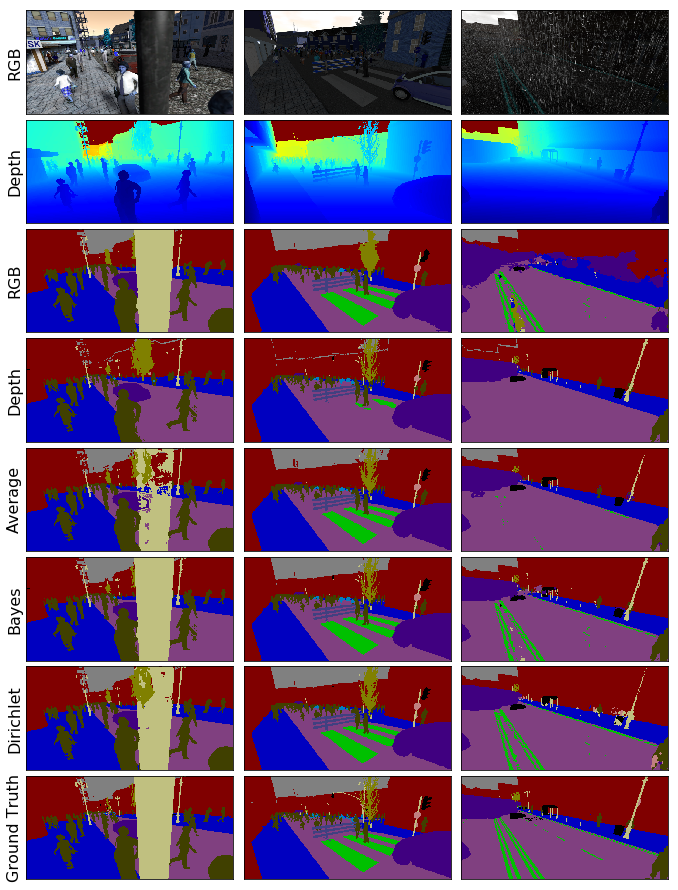

In [6]:
ncols = images['rgb'].shape[0]
label_params = {'fontsize': 16}
fig, axs = plt.subplots(8, ncols, figsize=(11.5,16), gridspec_kw = {'wspace':.05, 'hspace':.05})

for col in range(ncols):
    axs[0][col].imshow(images['rgb'][col].astype('int'))
    axs[1][col].imshow(np.log(np.squeeze(images['depth'][col])), cmap='jet')
    axs[2][col].imshow(data.coloured_labels(predictions['rgb'][col]))
    axs[3][col].imshow(data.coloured_labels(predictions['depth'][col]))
    axs[4][col].imshow(data.coloured_labels(predictions['average'][col]))
    axs[5][col].imshow(data.coloured_labels(predictions['bayes'][col]))
    axs[6][col].imshow(data.coloured_labels(predictions['dirichlet'][col]))
    axs[7][col].imshow(data.coloured_labels(images['labels'][col]))

for row, title in {0: 'RGB', 1: 'Depth', 2: 'RGB', 3: 'Depth', 4: 'Average', 5: 'Bayes',
                   6: 'Dirichlet', 7: 'Ground Truth'}.items():
    axs[row][0].set_ylabel(title, **label_params)
    for ax in axs[row]:
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

# Quantitative Evaluation of 'Synthia RAND' Fusion

In the following, we compare the different fusion methods quantitatively and show how the tables in the paper were produced.  
The function `print_tables` simply loads the measurements out of the referenced experiments and displays all results in a table. In particular, these cells do not measure the model's against the Cityscapes test set, but load measurement results that were produced by the authors.  
Below the tables we show how to revalidate the measurement results.

In [10]:
def print_tables(data, **experiments):
    table_data = {}
    for key, experiment_id in experiments.items():
        measurements = ExperimentData(experiment_id).get_record()['info']['measurements']
        if key == 'bayes':
            table_data[key.title()] = measurements['fusion']['IoU']
            # with the bayes experiments, we also measure the single baselines
            for modality in ('RGB', 'Depth'):
                table_data[modality] = measurements[modality.lower()]['IoU']
        else:
            table_data[key.title()] = measurements['IoU']
        
    classes = pd.DataFrame(table_data, index=[i['name'] for i in data.labelinfo.values()])
    mean = pd.DataFrame({col: classes[col][1:].mean() for col in classes.columns}, index=['mean'])
    
    # now order the columns
    ordered_columns = []
    for key in ['Fusion_Fcn', 'Dirichlet', 'Bayes', 'Average', 'Variance', 'RGB', 'Depth']:
        if key in classes.columns:
            ordered_columns.append(key)
    return mean.append(classes)[ordered_columns]
pd.set_option('display.precision', 4)

**1. Without Lanemarkings** (Part of Table I)

In [11]:
print_tables(SynthiaCityscapes(), bayes=838, average=839, dirichlet=857)

,Dirichlet,Bayes,Average,RGB,Depth
mean,0.7727,0.7862,0.7870,0.7339,0.7270
void,0.4880,0.6539,0.6245,0.6490,0.4251
sky,0.9702,0.9672,0.9581,0.9426,0.6413
building,0.9603,0.9597,0.9567,0.9235,0.8903
road,0.8818,0.9165,0.9180,0.8990,0.8843
sidewalk,0.9422,0.9314,0.9342,0.8978,0.9299
fence,0.7243,0.7047,0.7261,0.6575,0.6893
vegetation,0.8908,0.8952,0.8831,0.7860,0.8883
pole,0.5933,0.6215,0.6193,0.5128,0.5815
car,0.8880,0.8871,0.9106,0.8530,0.8746


**2. With Lanemarkings** (Tables I and II)

In [12]:
print_tables(SynthiaCityscapes(labels={'lanemarkings': True}), bayes=820, average=819, dirichlet=856)

,Dirichlet,Bayes,Average,RGB,Depth
mean,0.8019,0.7991,0.7905,0.7592,0.6376
void,0.7987,0.7531,0.7985,0.7386,0.7192
sky,0.9739,0.9741,0.9557,0.9554,0.0947
building,0.9685,0.9676,0.9620,0.9370,0.7986
road,0.9409,0.9278,0.9311,0.9158,0.8892
sidewalk,0.9507,0.9404,0.9470,0.9171,0.9360
fence,0.7476,0.7297,0.7454,0.6830,0.7189
vegetation,0.8989,0.9062,0.9002,0.8142,0.9032
pole,0.6553,0.6642,0.6479,0.5617,0.6019
car,0.9319,0.9139,0.9281,0.8781,0.9056


**3. More Methods with FCN** (Table V)

In [13]:
print_tables(SynthiaCityscapes(), bayes=836, variance=823, fusion_fcn=841, average=842, dirichlet=862)

,Fusion_Fcn,Dirichlet,Bayes,Average,Variance,RGB,Depth
mean,0.7690,0.6696,0.7499,0.7638,0.6635,0.7224,0.7201
void,0.6813,0.4668,0.6521,0.6216,0.4606,0.6463,0.4357
sky,0.9739,0.9712,0.9711,0.9674,0.9513,0.9372,0.9712
building,0.9558,0.9482,0.9499,0.9486,0.9109,0.9190,0.9456
road,0.9221,0.8699,0.8984,0.9041,0.8270,0.8967,0.7803
sidewalk,0.9322,0.8798,0.9114,0.9164,0.8347,0.8998,0.8101
fence,0.6897,0.3618,0.6260,0.6751,0.5945,0.6274,0.6483
vegetation,0.8869,0.8167,0.8652,0.8603,0.7975,0.7942,0.8592
pole,0.5320,0.4417,0.5110,0.5385,0.3678,0.4693,0.4879
car,0.9042,0.8232,0.8750,0.8997,0.7734,0.8554,0.8494


## How to reproduce quantitative measurements

To reproduce the evaluation experiments listed above, simply run the following cell with the correct `experiment_id`. The command will run the exact same script that was used to produce the measurement results. It will load the pretrained models, measure them on the measurement-set and use the measurements to produce decision functions for the bayes fusion or dirichlet fusion. Again, all the configurations of an experiment_id can be accessed with `ExperimentData(<experiment_id>).get_record()['config']`.  
More info on the experiment management can be found [here](http://sacred.readthedocs.io/en/latest/).

In [9]:
! python -m experiments.rerun with experiment_id=842 -u

WARNING - root - Added new config entry: "experiment_id"
INFO - rerun - Running command 'rerun'
INFO - rerun - Started
Re-Run of experiment "FCN syncity average fusion"
2018-07-20 15:44:12.388099: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
INFO Environment Variable TMPDIR not set, could not unpack data and load into memory
Now trying to load every image seperately
/home/spadmin/Dropbox/ETH/Masterarbeit/documentation/iros_paper/newdata/725/SimpleFCN_weights_28301.npz
/home/spadmin/Dropbox/ETH/Masterarbeit/documentation/iros_paper/newdata/671/SimpleFCN_weights_100000.npz
2018-07-20 15:44:17.003506: W tensorflow/core/framework/allocator.cc:108] Allocation of 301989888 exceeds 10% of system memory.
2018-07-20 15:44:17.124732: W tensorflow/core/framework/allocator.cc:108] Allocation of 301989888 exceeds 10% of system memory.
2018-07-20 15:44:19.887611: W tensorflow/core/framework/allocator